In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
dataset=pd.read_csv("train.csv")

In [3]:
dataset.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32


In [4]:
dataset.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


Extract hours and months features from datetime column 

In [5]:
dataset["hour"]=pd.DataFrame(dataset.datetime.apply(lambda x:x.split()[1].split(":")[0]))
dataset['hour'] = dataset['hour'].astype('int64')
dataset["month"]=pd.DataFrame(dataset.datetime.apply(lambda x:x.split()[0].split("-")[1]))
dataset['month'] = dataset['month'].astype('int64')
dataset=dataset[['season','holiday','workingday','weather','hour','month','temp','humidity','windspeed','count']]
dataset.describe()

,season,holiday,workingday,weather,hour,month,temp,humidity,windspeed,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,11.541613,6.521495,20.23086,61.886460,12.799395,191.574132
std,1.116174,0.166599,0.466159,0.633839,6.915838,3.444373,7.79159,19.245033,8.164537,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.82000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,6.000000,4.000000,13.94000,47.000000,7.001500,42.000000
50%,3.000000,0.000000,1.000000,1.000000,12.000000,7.000000,20.50000,62.000000,12.998000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,18.000000,10.000000,26.24000,77.000000,16.997900,284.000000
max,4.000000,1.000000,1.000000,4.000000,23.000000,12.000000,41.00000,100.000000,56.996900,977.000000


Filter out the outlier data

In [6]:
upper_bound=dataset['count'].mean()+3*dataset['count'].std()
lower_bound=dataset['count'].mean()-3*dataset['count'].std()
dataset=dataset[dataset["count"]<upper_bound]
dataset=dataset[dataset["count"]>lower_bound]

In [7]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

Adding dummy varibles for categorical feature 'season'  'holiday'  'workingday'  'weather'  'hour'  'month'

In [8]:
labelencoder = LabelEncoder()
onehotencoder = OneHotEncoder(categorical_features = range(6))
X = onehotencoder.fit_transform(X).toarray()

Division training set and testing set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
import xgboost as xgb
from sklearn import metrics
import MeasurePreprocess
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


Choosing the xgboost to regression and applying GridSearchCV for optimal  parameter 

In [11]:
forest_reg01 = xgb.XGBRegressor()
param_test01=[{'max_depth':[6,7,8,9,10],'min_child_weight':range(5,10)}]
gsearch1 = GridSearchCV(forest_reg01, param_test01, cv=5,return_train_score=True)
gsearch1.fit(X_train,y_train)
print gsearch1.best_params_, gsearch1.best_score_

{'max_depth': 10, 'min_child_weight': 8} 0.83598220439


In [12]:
forest_reg02 = xgb.XGBRegressor(max_depth=10,min_child_weight=8)
param_test02=[{'gamma':[0,1,2,3,4,5],'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,1]}]
gsearch2 = GridSearchCV(forest_reg02, param_test02, cv=5,return_train_score=True)
gsearch2.fit(X_train,y_train)
print gsearch2.best_params_, gsearch2.best_score_

{'colsample_bytree': 0.8, 'gamma': 4} 0.838352724451


Grid search gives best parameter for 'max_depth'= 10 'min_child_weight'=8 'colsample_bytree'= 0.8 'gamma'= 4

applying cross_val_score for these new parameters

In [13]:
xlf = xgb.XGBRegressor(max_depth=10,min_child_weight=8,gamma=4,colsample_bytree=0.8)
scores = cross_val_score(xlf, X_train,y_train, cv=5)
print"Cross validation scores:",scores

Cross validation scores: [ 0.83592285  0.83862756  0.83806972  0.83190081  0.8472441 ]


Training a model with these new parameters

In [14]:
xlf = xlf.fit(X_train, y_train)
y_pred=xlf.predict(X_test)
metrics.mean_squared_error(y_test, y_pred)
print"MSE:",metrics.mean_squared_error(y_test, y_pred)

MSE: 4414.09082941


Define a function for calculation error rate ---|test-pred|/test

In [15]:
def ErrorRate(test,pred):
    avg=[0]*len(test)
    for i in range(len(test)):
        try:
            avg[i]=abs(float(test[i]) - float(pred[i]))/float(test[i])
        except ZeroDivisionError,e:
            print e.message
    avg=np.array(avg)
    return avg.mean()

In [16]:
print"Error rate:",MeasurePreprocess.ErrorRate(y_test,y_pred)

Error rate: 0.638691679657


Visualization of prediction results 

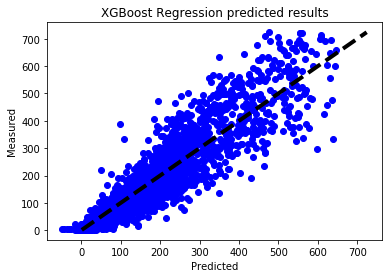

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(y_pred,y_test,color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.ylabel('Measured')
plt.xlabel('Predicted')
plt.title("XGBoost Regression predicted results")
plt.show()